# Creating a Decision Tree

- Doesnt care about long tailed variables, outliers etc 
- very robust

In [1]:
from fastai.imports import *

OneR method repeated againimport os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

## Preprocessing

In [2]:
import os

path = Path('titanic')
df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

In [3]:
# Standard processing steps
df.fillna(modes, inplace = True)
df['Fare'].fillna(0, inplace = True)

In [4]:
df['LogFare'] = np.log1p(df['Fare']) #does +1 for you to ensure no zeros

In [5]:
df['Embarked'] = pd.Categorical(df.Embarked)
df['Sex'] = pd.Categorical(df.Sex)

In [6]:
cats = ['Sex', 'Embarked']
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'] # note Pclass is treated as a continuous variable because its ordered
tgt = "Survived"

In [7]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes) # replacing all categorical variables with a integer code (e.g. 1,2,3) (basically their pos in array)

In [8]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[tgt] if tgt in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [9]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [10]:
m = DecisionTreeClassifier(max_leaf_nodes = 4).fit(trn_xs, trn_y)

In [11]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

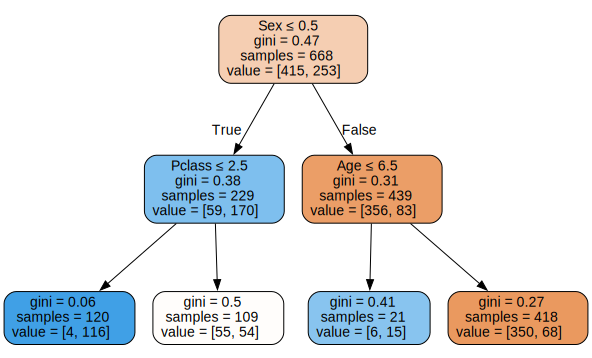

In [12]:
draw_tree(m, trn_xs, size = 10)

Gini coefficient:
- How likely will you grab the same item from a sample each time
- if theres only 1 type, gini will be 1

In [13]:
def gini(cond):
    act = df.loc[cond, tgt]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [14]:
gini(df.Sex == 'female')

0.3828350034484158

## Random Forest

- Random collection of decision trees, which are biased
- Arent sensitive to normalisation, interactions or non-linear transformations
- by averaging over all the decision trees, a performance better than any tree can be achieved

- Great for explainability but, if the model is inaccurate, the insights derived from explainability is not useful

In [17]:
def get_tree(prop = 0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [18]:
tree = get_tree()

In [19]:
trees = [get_tree() for t in range(100)]

In [22]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

NameError: name 'mean_absolute_error' is not defined

In [23]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, avg_probs)

0.2265470852017937

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18385650224215247

## Feature Importances and Interpretation

Calculated by:
- loops through each tree and explores each branch
- looks at where the model splits, and how much the model improves as a result of that split
- summed and normalised to 1
https://forecastegy.com/posts/feature-importance-in-random-forests/#:~:text=Permutation%20feature%20importance%20is%20another,out%2Dof%2Dsample%20dataset.

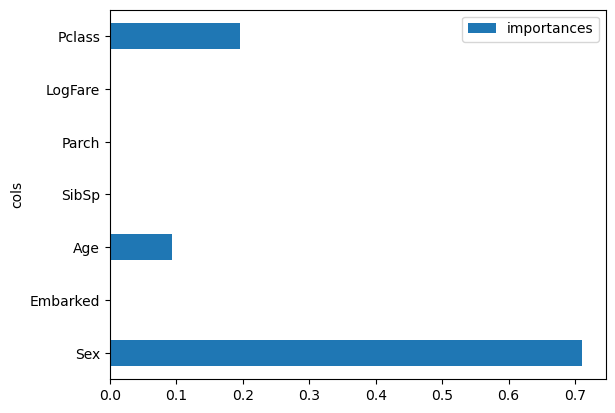

In [31]:
pd.DataFrame(dict(cols=trn_xs.columns, importances=m.feature_importances_)).plot('cols', 'importances', 'barh');